### Notebook for Supplementary Figure 7, show the empty channels in the bulk dataset

In [25]:
%matplotlib inline
import os
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import sceptre as spt

## Preparation
Create meta data table and load files into python as "dataset". Alternatively, a meta data table could be created manually and be provided to the function: sceptre.load_dataset()
Mapping is performed with the "File ID" and "Channel" columns.

In [26]:
# create result folder
res_dir = '../results/bulk_show_empty/'
if not os.path.exists(res_dir):
    os.makedirs(res_dir)

In [27]:
dataset = spt.load_dataset(proteins = "../data/bulk/bulk_Proteins.txt",
                           psms = "../data/bulk/bulk_PSMs.txt",
                           msms = "../data/bulk/bulk_MSMSSpectrumInfo.txt",
                           files = "../data/bulk/bulk_InputFiles.txt",
                           meta = "../results/bulk/meta.txt")

In [28]:
# mark and remove potential contaminants
contaminants = pd.read_table('../data/contaminants.txt')['Accession']
dataset['proteins']['contaminant'] = dataset['proteins']['Accession'].isin(contaminants)
dataset['proteins'] = dataset['proteins'][dataset['proteins']['contaminant']==False]

In [29]:
figwd = 7.2 # standard figwidth

## Load data into Scanpy

In [30]:
adata = spt.dataset_to_scanpy(dataset)

In [31]:
# transform meta columns to categories
adata.obs["Column"] = adata.obs["Column"].astype(pd.Int64Dtype()).astype("category")
adata.obs["Plate"] = adata.obs["Plate"].astype(str).astype("category")
# object columns to category
adata.obs.loc[:, adata.obs.dtypes == "object"] = adata.obs.select_dtypes(["object"]
                                                                          ).apply(lambda x: x.astype("category"))
# order some columns
adata.obs["File ID"] = adata.obs["File ID"].cat.reorder_categories(adata.obs["File ID"].unique(), ordered=True)
adata.obs["Channel"] = adata.obs["Channel"].cat.reorder_categories(adata.obs["Channel"].unique(), ordered=True)

# normalize facs parameter between 0 and 1
fasc_params = ['FSC-A', 'FSC-H', 'FSC-W', 'SSC-A', 'SSC-H', 'SSC-W', 'APC-Cy7-A', 'PE-A']
adata.obs[fasc_params] = adata.obs[fasc_params].apply(lambda x: (x-x.min())/(x-x.min()).max())

# rename the facs parameter
adata.obs = adata.obs.rename(columns={'APC-Cy7-A': 'CD34 APC-Cy7-A', 'PE-A': 'CD38 PE-A'})

# set colors for gated and sorted populations
cols = plt.rcParams['axes.prop_cycle'].by_key()['color']
adata.uns['Sorted Population_colors'] = [cols[0], cols[1], cols[2]]
adata.uns['Gated Population_colors'] = [cols[3], cols[0], cols[1], cols[2]]

## Filter samples, channels and groups of cells

In [32]:
# remove failed ms runs
adata = adata[~adata.obs['File ID'].isin(['F5', 'F44', 'F58', 'F117'])].copy()
# remove non-single-cell cannel
adata = adata[~adata.obs['Channel'].isin(['126', '127C', '127N'])].copy()

/home/bfurtwa/miniconda3/envs/sceptre_test/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


## Normalization

In [33]:
spt.normalize(adata)

performed 17 iterations
5797 values below 1.1 were set to 0
filtered out 58 genes that are detected in less than 1 cells


## Cell QC

396 of 2444 cells do not pass filter


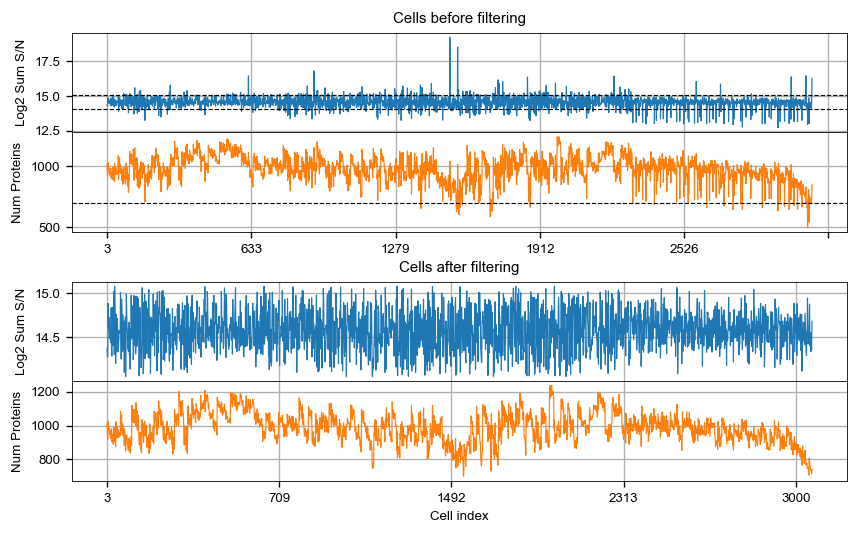

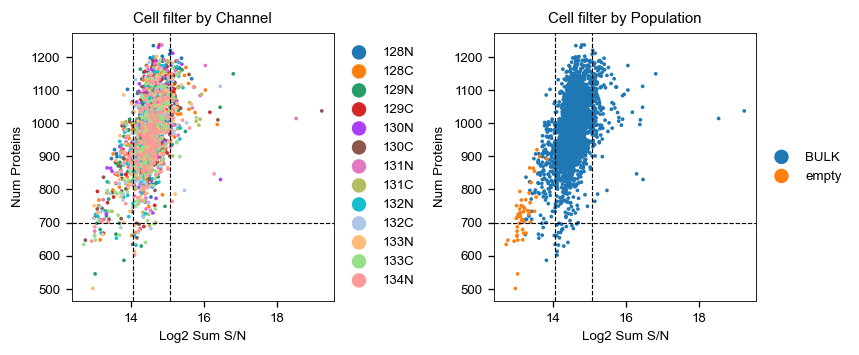

In [34]:
figs = spt.calculate_cell_filter(adata, thresh_sum=1.8, min_proteins=700)
figs[0].savefig(res_dir + "cell_filter_1.pdf", bbox_inches='tight', transparent=True)
figs[1].savefig(res_dir + "cell_filter_2.pdf", bbox_inches='tight', transparent=True)